In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
==> Preparing data..
==> Building model..

Epoch: 1/80 -- LR: 0.10000
  Train Batch 100/391 | Loss: 2.115 | Acc: 21.633% (2769/12800) | BatchTime: 0.058s | DataTime: 0.003s
  Train Batch 200/391 | Loss: 1.988 | Acc: 25.305% (6478/25600) | BatchTime: 0.057s | DataTime: 0.003s
  Train Batch 300/391 | Loss: 1.893 | Acc: 28.786% (11054/38400) | BatchTime: 0.057s | DataTime: 0.002s
  Train Batch 391/391 | Loss: 1.832 | Acc: 31.126% (15563/50000) | BatchTime: 0.057s | DataTime: 0.002s
Test Results: Loss: 1.699 | Acc: 38.600% (3860/10000)
Epoch 1 duration: 24.32 seconds. Validation Loss: 1.6991, Validation Acc: 38.60%
Validation loss improved. Best model saved to best_resnet32_cifar10.pth

Epoch: 2/80 -- LR: 0.09996
  Train Batch 100/391 | Loss: 1.540 | Acc: 42.445% (5433/12800) | BatchTime: 0.057s | DataTime: 0.003s
  Train Batch 200/391 | Loss: 1.499 | Acc: 44.348% (11353/25600) | BatchTime: 0.056s | DataTime: 0.003s
  Train Batch 300/391 | Loss: 1.448 | Acc: 46.604% (178

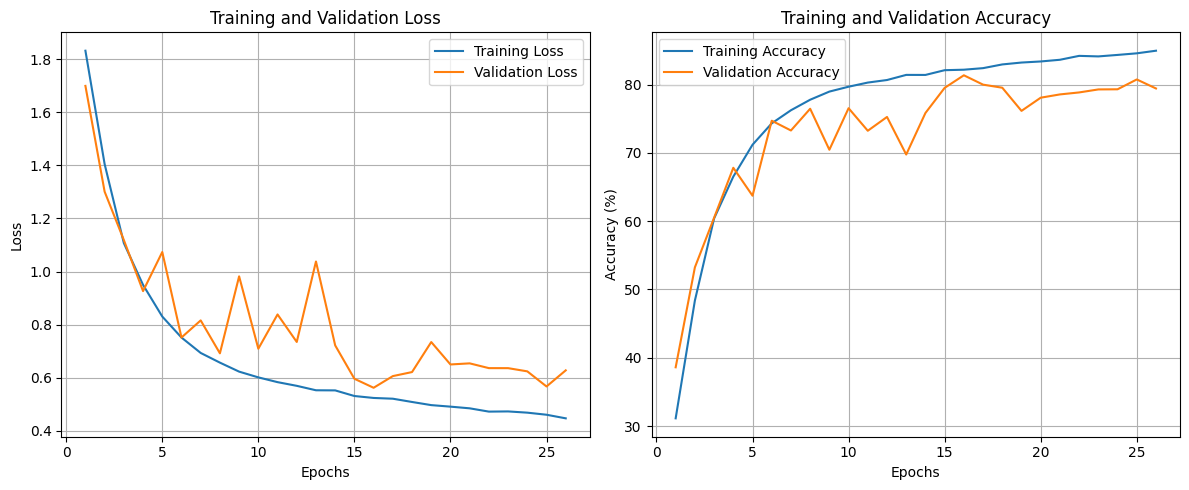

==> Training finished. Plots saved to resnet32_cifar10_training_plots_with_overfitting_reduction.png
Best validation loss achieved: 0.5623

==> Evaluating best model on test set...
Test Results: Loss: 0.562 | Acc: 81.350% (8135/10000)
Final Test Performance of Best Model: Loss: 0.5623, Accuracy: 81.35%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy # For saving best model state

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Hyperparameters for Overfitting Reduction ---
MAX_EPOCHS = 80          # Increased max epochs, early stopping will manage
PATIENCE_EARLY_STOPPING = 10 # Stop if val_loss doesn't improve for 10 epochs
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4      # Common value for ResNets on CIFAR-10
USE_DROPOUT = True       # Set to True to add dropout
DROPOUT_RATE = 0.2       # Dropout rate if USE_DROPOUT is True

BATCH_SIZE = 128
MODEL_SAVE_PATH = 'best_resnet32_cifar10.pth'

# --- Data Preparation ---
print("==> Preparing data..")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# --- ResNet Model Definition (Same as before, but with optional dropout) ---
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, use_dropout=False, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.use_dropout = use_dropout

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)
            
        self.linear = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_planes, planes, s))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        if self.use_dropout:
            out = self.dropout(out) # Apply dropout before the final linear layer
        out = self.linear(out)
        return out

def ResNet32(use_dropout=False, dropout_rate=0.5):
    return ResNet(BasicBlock, [5, 5, 5], use_dropout=use_dropout, dropout_rate=dropout_rate)

# --- Model Initialization, Loss, Optimizer ---
print('==> Building model..')
net = ResNet32(use_dropout=USE_DROPOUT, dropout_rate=DROPOUT_RATE)
net = net.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
                      momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Using CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

# --- Training Function ---
def train(epoch):
    print(f'\nEpoch: {epoch+1}/{MAX_EPOCHS} -- LR: {scheduler.get_last_lr()[0]:.5f}')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_time_sum = 0
    data_time_sum = 0
    
    end_time = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        data_time = time.time() - end_time
        
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        batch_time = time.time() - end_time
        end_time = time.time()
        
        batch_time_sum += batch_time
        data_time_sum += data_time

        if (batch_idx + 1) % 100 == 0 or batch_idx == len(trainloader)-1:
            print(f'  Train Batch {batch_idx+1}/{len(trainloader)} | Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total}) '
                  f'| BatchTime: {batch_time_sum/(batch_idx+1):.3f}s | DataTime: {data_time_sum/(batch_idx+1):.3f}s')
    
    avg_loss = train_loss / len(trainloader)
    avg_acc = 100. * correct / total
    return avg_loss, avg_acc

# --- Testing Function ---
def test(): # Removed epoch argument as it's not directly used for decision here
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # if (batch_idx + 1) % 50 == 0 or batch_idx == len(testloader)-1:
            #     print(f'  Test Batch {batch_idx+1}/{len(testloader)} | Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')

    avg_loss = test_loss / len(testloader)
    avg_acc = 100. * correct / total
    print(f'Test Results: Loss: {avg_loss:.3f} | Acc: {avg_acc:.3f}% ({correct}/{total})')
    return avg_loss, avg_acc

# --- Main Training Loop & Plotting with Early Stopping ---
train_losses, val_losses = [], [] # Renamed test_losses to val_losses for clarity
train_accs, val_accs = [], []   # Renamed test_accs to val_accs

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_weights = None

start_total_time = time.time()

for epoch in range(MAX_EPOCHS):
    epoch_start_time = time.time()
    
    tr_loss, tr_acc = train(epoch)
    val_loss, val_acc = test() # Test function now represents validation
    scheduler.step() 

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1} duration: {epoch_duration:.2f} seconds. Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model state
        best_model_weights = copy.deepcopy(net.state_dict())
        torch.save(best_model_weights, MODEL_SAVE_PATH)
        print(f"Validation loss improved. Best model saved to {MODEL_SAVE_PATH}")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

    if epochs_no_improve >= PATIENCE_EARLY_STOPPING:
        print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
        # Load the best model weights before finishing
        if best_model_weights:
            net.load_state_dict(best_model_weights)
            print("Loaded best model weights.")
        break # Exit the training loop

total_training_time = time.time() - start_total_time
print(f"\nTotal training time: {total_training_time/60:.2f} minutes")

# --- Plotting Results ---
# Adjust epochs_range if early stopping occurred
actual_epochs = len(train_losses)
epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label='Training Accuracy')
plt.plot(epochs_range, val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('resnet32_cifar10_training_plots_with_overfitting_reduction.png')
plt.show()

print(f"==> Training finished. Plots saved to resnet32_cifar10_training_plots_with_overfitting_reduction.png")
print(f"Best validation loss achieved: {best_val_loss:.4f}")

# Evaluate the best model one last time on the test set
if best_model_weights:
    print("\n==> Evaluating best model on test set...")
    net.load_state_dict(torch.load(MODEL_SAVE_PATH)) # Load from saved file
    final_test_loss, final_test_acc = test()
    print(f"Final Test Performance of Best Model: Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.2f}%")
else:
    print("\n==> Evaluating last model on test set (early stopping might not have saved a 'best' model if no improvement from start)...")
    final_test_loss, final_test_acc = test()
    print(f"Final Test Performance of Last Model: Loss: {final_test_loss:.4f}, Accuracy: {final_test_acc:.2f}%")